In [3]:
import xml.etree.ElementTree as et
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

## Parse Apple Health Export document

In [4]:
path = "/home/sasdemo/apple_health_export/export.xml"
e = et.parse(path)

## List XML headers by element count

In [5]:
pd.Series([el.tag for el in e.iter()]).value_counts()

Record             231179
ActivitySummary       162
MetadataEntry         158
Workout                14
Correlation             7
WorkoutEvent            2
ExportDate              1
HealthData              1
Me                      1
dtype: int64

## List types for "Record" Header

In [6]:
pd.Series([atype.get('type') for atype in e.findall('Record')]).value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned           74776
HKQuantityTypeIdentifierBasalEnergyBurned            71769
HKQuantityTypeIdentifierHeartRate                    33960
HKQuantityTypeIdentifierDistanceWalkingRunning       27253
HKQuantityTypeIdentifierStepCount                    19344
HKQuantityTypeIdentifierAppleExerciseTime             1624
HKCategoryTypeIdentifierAppleStandHour                1451
HKQuantityTypeIdentifierFlightsClimbed                 873
HKQuantityTypeIdentifierDietaryWater                    39
HKQuantityTypeIdentifierBodyMass                        19
HKQuantityTypeIdentifierBodyTemperature                 11
HKQuantityTypeIdentifierBloodPressureSystolic            7
HKQuantityTypeIdentifierBloodPressureDiastolic           7
HKQuantityTypeIdentifierDietarySugar                     2
HKQuantityTypeIdentifierDietaryFatMonounsaturated        2
HKQuantityTypeIdentifierDietaryCarbohydrates             2
HKQuantityTypeIdentifierDietaryEnergyConsumed           

# Extract Values to Data Frame
TODO: Abstraction of the next code block

In [7]:
#Extract the heartrate values, and get a timestamp from the xml
# there is likely a more efficient way, though this is very fast
def extractXMLData(xmlElement, xmlValue):
    dt = []
    v = []
    for atype in e.findall(xmlElement):
        if atype.get('type') == xmlValue:
            dt.append(datetime.strptime(atype.get("startDate"),"%Y-%m-%d %H:%M:%S %z"))
            v.append(atype.get("value"))


    myd = pd.DataFrame({"Create":dt,xmlValue:v})
    myd['Month'] = myd['Create'].apply(lambda x: x.strftime('%Y-%m'))
    myd['Day'] = myd['Create'].apply(lambda x: x.strftime('%d'))
    myd['Hour'] = myd['Create'].apply(lambda x: x.strftime('%H'))

    return(myd)


In [11]:
myd = extractXMLData('Record',"HKQuantityTypeIdentifierHeartRate")
myd["HKQuantityTypeIdentifierHeartRate"] = myd.HKQuantityTypeIdentifierHeartRate.astype(float).astype(int)
myd.head()



,Create,HKQuantityTypeIdentifierHeartRate,Month,Day,Hour
0,2016-07-01 11:03:16-04:00,81,2016-07,01,11
1,2016-07-01 11:06:50-04:00,78,2016-07,01,11
2,2016-07-01 11:11:52-04:00,61,2016-07,01,11
3,2016-07-01 11:17:37-04:00,73,2016-07,01,11
4,2016-07-01 11:23:02-04:00,74,2016-07,01,11


HKQuantityTypeIdentifierHeartRate    Axes(0.1,0.15;0.8x0.75)
dtype: object

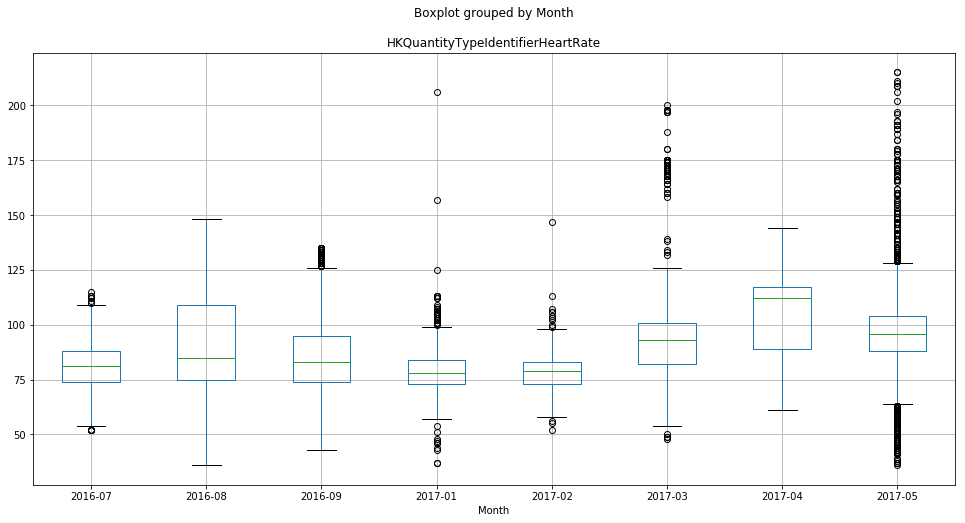

In [12]:
myd.boxplot(by='Month',column="HKQuantityTypeIdentifierHeartRate", return_type='axes')

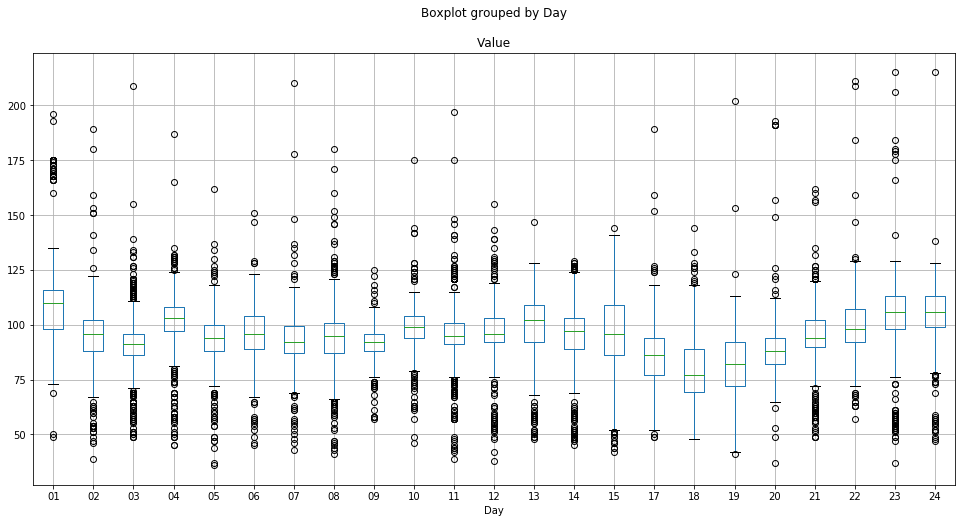

In [46]:
ax = myd[myd['Month']=='2017-05'].boxplot(by='Day',column="Value", return_type='axes')


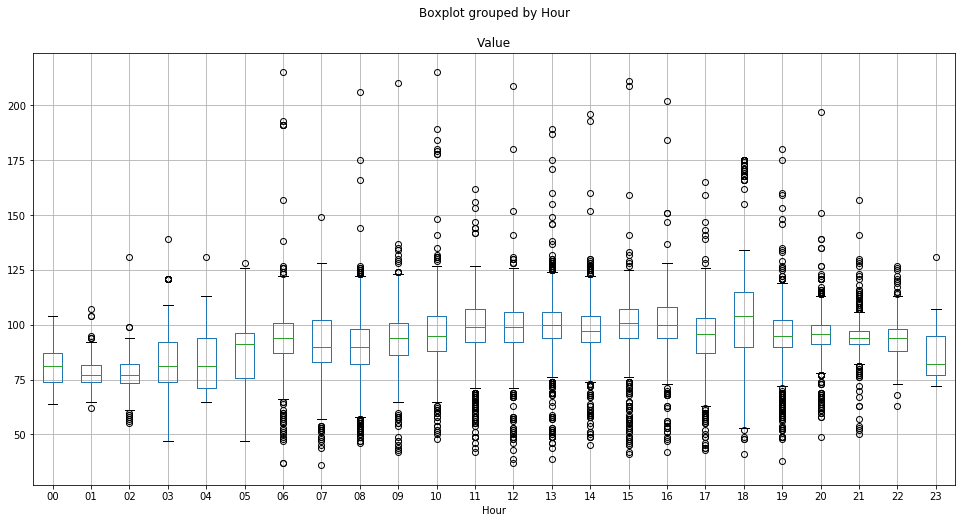

In [51]:
myd[myd['Month']=='2017-05'].boxplot(by='Hour',column="Value")

# Load data into CAS to explore in VA - Explanatory Version

In [13]:
from swat import *
cashost='localhost'
casport=5570
casauth='~/.authinfo'
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

In [14]:
# Load necessary actionsets
sess.loadactionset(actionset="table")

NOTE: Added action set 'table'.


[actionset]

 'table'

+ Elapsed: 0.00285s, user: 0.002s, sys: 0.000999s, mem: 0.0577mb

In [15]:
# list available caslibs
sess.caslibinfo()

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden
0,CASUSER(sasdemo),PATH,Personal File System Caslib,/home/sasdemo/casuser/,,1.0,0.0,1.0,1.0,0.0
1,DemoData,PATH,"DemoCenter Shared and writeable caslib, access...",/opt/sasinside/DemoData/,,0.0,0.0,0.0,0.0,0.0
2,Formats,PATH,Stores user defined formats.,/opt/sas/viya/config/data/cas/default/formats/,,1.0,0.0,0.0,0.0,0.0
3,Models,PATH,Stores models created by Visual Analytics for ...,/opt/sas/viya/config/data/cas/default/models/,,0.0,0.0,0.0,0.0,0.0
4,Public,PATH,"Shared and writeable caslib, accessible to all...",/opt/sas/viya/config/data/cas/default/public/,,1.0,0.0,0.0,0.0,0.0
5,SystemData,PATH,"Stores application generated data, used for ge...",/opt/sas/viya/config/data/cas/default/sysData/,,0.0,0.0,0.0,0.0,0.0


In [28]:
sess.droptable(name='AppleHeartrate')
upRes = sess.upload(data=myd,casout='AppleHeartrate')
sess.promote(name='AppleHeartrate')
ahr = upRes.casTable

NOTE: Cloud Analytic Services dropped table AppleHeartrate from caslib CASUSER(sasdemo).
NOTE: Cloud Analytic Services made the uploaded file available as table APPLEHEARTRATE in caslib CASUSER(sasdemo).
NOTE: The table APPLEHEARTRATE has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [24]:
sess.table.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,APPLEHEARTRATE,33960,5,utf-8,26May2017:12:21:15,26May2017:12:21:15,UTF8,1.811420e+09,1.811420e+09,1,0,0,,,0,sasdemo,


In [31]:
ahr.head()

,Create,HKQuantityTypeIdentifierHeartRate,Month,Day,Hour
0,2016-07-01 11:03:16-04:00,81.0,2016-07,1.0,11.0
1,2016-07-01 11:06:50-04:00,78.0,2016-07,1.0,11.0
2,2016-07-01 11:11:52-04:00,61.0,2016-07,1.0,11.0
3,2016-07-01 11:17:37-04:00,73.0,2016-07,1.0,11.0
4,2016-07-01 11:23:02-04:00,74.0,2016-07,1.0,11.0
